# Setup

Loading the data from google drive into colab

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
!cp ./gdrive/My\ Drive/zindi_hack/umoja/data/train/train.csv ./
!cp ./gdrive/My\ Drive/zindi_hack/umoja/data/test/test.csv ./
!cp ./gdrive/My\ Drive/zindi_hack/umoja/data/ss.csv ./

In [0]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt

In [8]:
train = pd.read_csv('train.csv', parse_dates=['date'])
train.head()

,ID,area,date,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation
0,0_2000-04-01,0,2000-04-01,25.447,5.296,0.003688,1250.622712,0.0,-178.916305,1250.622712,158.387765,8.000000,498.913776,2143.430034,0.0,206.935453,323.873675,2508.795159,115.989282,129.825024,590.564102,0.0,0.0,0.350169,0.0,0.649524,0.0,0.000307,0.0,0.0,2.214262,0.198996
1,1_2000-04-01,1,2000-04-01,25.669,5.293,0.000000,1238.019166,0.0,-150.779947,1238.019166,164.645065,8.104576,590.346191,2132.253953,0.0,204.835170,321.838884,2500.432319,112.619789,129.471370,611.544277,0.0,0.0,0.429049,0.0,0.570644,0.0,0.000307,0.0,0.0,3.833042,0.188071
2,2_2000-04-01,2,2000-04-01,25.443,5.074,0.000000,1240.449964,0.0,-200.503858,1240.449964,163.699542,8.027851,536.613938,2139.632626,0.0,207.001206,321.846757,2519.259344,112.378707,127.550639,594.188987,0.0,0.0,0.238300,0.0,0.761700,0.0,0.000000,0.0,0.0,1.927303,0.211730
3,3_2000-04-01,3,2000-04-01,25.665,5.070,0.000000,1229.240077,0.0,-177.011032,1229.240077,172.996043,8.820002,648.271615,2125.206979,0.0,204.127473,319.348123,2493.392613,109.132390,131.703082,645.362481,0.0,0.0,0.488146,0.0,0.511854,0.0,0.000000,0.0,0.0,1.878281,0.215403
4,4_2000-04-01,4,2000-04-01,25.886,5.067,0.000307,1224.093679,0.0,-153.256111,1224.093679,178.396749,9.000000,719.423119,2114.709813,0.0,203.295123,318.639735,2487.984467,108.161469,133.354846,660.372381,0.0,0.0,0.322243,0.0,0.677757,0.0,0.000000,0.0,0.0,1.968818,0.199975


In [9]:
test = pd.read_csv('test.csv', parse_dates=['date'])
test.head()

,ID,area,date,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation
0,0_2014-01-01,0,2014-01-01,25.447,5.296,0,142.756021,1217.926180,-953.401012,1360.571291,1.000000,0.0,355.593690,2349.499157,0.0,187.541787,332.578998,2542.124518,111.013969,156.563945,590.564102,0.0,0.0,0.430648,0.0,0.569045,0.0,0.000307,0.0,0.0,2.773423,0.000457
1,1_2014-01-01,1,2014-01-01,25.669,5.293,0,154.836847,1193.866315,-961.703043,1348.688788,1.000000,0.0,382.206636,2340.597389,0.0,185.895903,330.826066,2551.085649,106.576545,158.165429,611.544277,0.0,0.0,0.494624,0.0,0.505068,0.0,0.000307,0.0,0.0,4.697883,0.000129
2,2_2014-01-01,2,2014-01-01,25.443,5.074,0,127.790933,1223.640222,-962.435857,1351.521823,1.000000,0.0,318.078852,2351.867856,0.0,188.441645,330.077285,2551.183265,107.104292,153.257656,594.188987,0.0,0.0,0.288343,0.0,0.711657,0.0,0.000000,0.0,0.0,2.488614,0.000398
3,3_2014-01-01,3,2014-01-01,25.665,5.070,0,136.924571,1201.258784,-961.326298,1338.120278,1.000000,0.0,339.386497,2348.509414,0.0,185.393692,326.942319,2539.815326,101.962346,155.518048,645.362481,0.0,0.0,0.492103,0.0,0.507897,0.0,0.000000,0.0,0.0,2.439959,0.000158
4,4_2014-01-01,4,2014-01-01,25.886,5.067,0,144.278146,1197.831547,-959.248284,1342.118844,0.998555,0.0,358.043829,2341.881156,0.0,186.275015,327.839976,2549.462252,102.743046,159.865021,660.372381,0.0,0.0,0.333855,0.0,0.666145,0.0,0.000000,0.0,0.0,2.546723,0.000153


#Feature Engineering

Date features

In [0]:
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year

Adding some more features

In [0]:
train['dry_and_windy'] = (1/train['climate_soil'])*train['climate_vs']
train['hot_and_dry'] = train['climate_srad'] *(1/train['climate_soil'])
train['low_pres_and_rain_def'] = train['climate_def'] *(1/train['climate_vap'])
train['pres_def_and_windy'] = (1/train['climate_aet'])*train['climate_vs']

test['dry_and_windy'] = (1/test['climate_soil'])*test['climate_vs']
test['hot_and_dry'] = test['climate_srad'] *(1/test['climate_soil'])
test['low_pres_and_rain_def'] = test['climate_def'] *(1/test['climate_vap'])
test['pres_def_and_windy'] = (1/test['climate_aet'])*test['climate_vs']

Looking at the new features correlation to the target variable

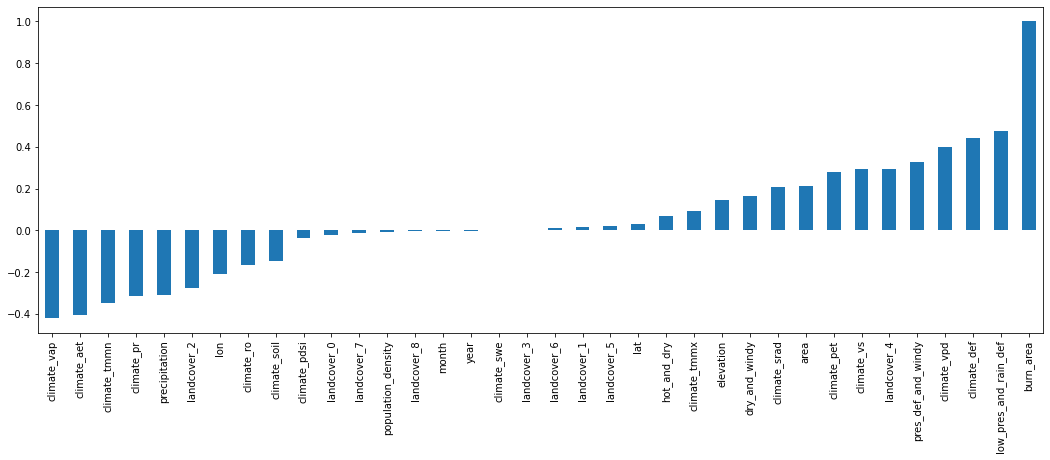

In [12]:
train.corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

#Training



In [0]:
from fastai.tabular import * 

In [14]:
train = train.drop(columns=['ID', 'area', 'date'])
train.head()

,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation,month,year,dry_and_windy,hot_and_dry,low_pres_and_rain_def,pres_def_and_windy
0,25.447,5.296,0.003688,1250.622712,0.0,-178.916305,1250.622712,158.387765,8.000000,498.913776,2143.430034,0.0,206.935453,323.873675,2508.795159,115.989282,129.825024,590.564102,0.0,0.0,0.350169,0.0,0.649524,0.0,0.000307,0.0,0.0,2.214262,0.198996,4,2000,0.260215,4.296193,0.0,0.103808
1,25.669,5.293,0.000000,1238.019166,0.0,-150.779947,1238.019166,164.645065,8.104576,590.346191,2132.253953,0.0,204.835170,321.838884,2500.432319,112.619789,129.471370,611.544277,0.0,0.0,0.429049,0.0,0.570644,0.0,0.000307,0.0,0.0,3.833042,0.188071,4,2000,0.219314,3.611870,0.0,0.104579
2,25.443,5.074,0.000000,1240.449964,0.0,-200.503858,1240.449964,163.699542,8.027851,536.613938,2139.632626,0.0,207.001206,321.846757,2519.259344,112.378707,127.550639,594.188987,0.0,0.0,0.238300,0.0,0.761700,0.0,0.000000,0.0,0.0,1.927303,0.211730,4,2000,0.237695,3.987285,0.0,0.102826
3,25.665,5.070,0.000000,1229.240077,0.0,-177.011032,1229.240077,172.996043,8.820002,648.271615,2125.206979,0.0,204.127473,319.348123,2493.392613,109.132390,131.703082,645.362481,0.0,0.0,0.488146,0.0,0.511854,0.0,0.000000,0.0,0.0,1.878281,0.215403,4,2000,0.203160,3.278266,0.0,0.107142
4,25.886,5.067,0.000307,1224.093679,0.0,-153.256111,1224.093679,178.396749,9.000000,719.423119,2114.709813,0.0,203.295123,318.639735,2487.984467,108.161469,133.354846,660.372381,0.0,0.0,0.322243,0.0,0.677757,0.0,0.000000,0.0,0.0,1.968818,0.199975,4,2000,0.185364,2.939452,0.0,0.108942


In [15]:
train.shape

(626644, 35)

Defining the categorical, continuous and dependant variables for the tabular learner

In [16]:
cols = train.columns.tolist()
dep_var = 'burn_area'
cat_var = cols[0:2] + cols[29:31]
cont_var = cols[3:29] + cols[31:35]
print(cat_var, cont_var)

['lat', 'lon', 'month', 'year'] ['climate_aet', 'climate_def', 'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro', 'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn', 'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation', 'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3', 'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7', 'landcover_8', 'population_density', 'precipitation', 'dry_and_windy', 'hot_and_dry', 'low_pres_and_rain_def', 'pres_def_and_windy']


In [0]:
procs = [FillMissing, Categorify, Normalize]

I trained 5 different models, each time changing the random validation split seed to 42, 43, 44, 45 and 46 respectively

In [0]:
#seeds: 42, 43, 44, 45, 46
data = (TabularList.from_df(train, procs = procs, cont_names = cont_var, cat_names = cat_var).split_by_rand_pct(valid_pct = 0.1,seed=42)
        .label_from_df(cols=dep_var)
        .add_test(TabularList.from_df(test.drop(columns=['ID', 'area', 'date']), procs = procs, cont_names=cont_var, cat_names = cat_var))
        .databunch())

In [0]:
data.batch_size = 4096

In [20]:
learn = tabular_learner(data, layers=[500,200], metrics=root_mean_squared_error, y_range=(0,1))
data.show_batch()

lat,lon,month,year,population_density_na,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation,dry_and_windy,hot_and_dry,low_pres_and_rain_def,pres_def_and_windy,target
24.962,1.072,8,2006,False,0.3362,-0.6011,-0.0637,-0.7460,0.4029,0.4558,-0.2900,-0.7537,-0.0018,0.6151,-0.5770,0.3507,-0.5219,-0.7608,-0.5873,-0.1408,-0.0503,0.6983,-0.0190,-0.5992,-0.0548,-0.3064,-0.0742,-0.1254,-0.1055,1.0893,-0.4787,-0.3958,-0.5218,-0.3316,0.0
23.69,-6.749,5,2012,False,0.1368,0.1421,-0.2102,0.5427,-0.9268,-0.6607,-0.4477,0.4955,-0.0018,-0.5564,0.5613,-1.0554,1.2756,0.0678,0.0128,-0.1408,-0.0503,-2.2801,-0.0190,-0.5992,-0.0548,11.0389,-0.0742,-0.1254,0.6795,-0.7743,-0.1887,-0.1897,0.0796,-0.2275,0.0006147252
26.285,-0.7070000000000001,10,2003,False,0.7385,-0.6011,1.5775,-0.0645,2.4596,3.4427,-0.6091,-0.4122,-0.0018,0.3605,0.5867,0.3015,0.1621,-0.3840,-0.4848,-0.1408,-0.0503,0.6983,-0.0190,-0.5992,-0.0548,-0.3064,-0.0742,-0.1254,-0.1264,0.4187,-0.1752,-0.1488,-0.5218,-0.3206,0.0
28.48,0.838,4,2013,False,0.8815,-0.6011,-1.4224,0.1776,0.2916,-0.5613,-0.3559,0.7834,-0.0018,-0.5768,-0.9131,-0.3542,-0.4986,0.3627,0.4718,-0.1408,-0.0503,0.6983,-0.0190,-0.5992,-0.0548,-0.3064,-0.0742,-0.1254,-0.1263,0.3670,-0.1857,-0.2276,-0.5218,-0.2631,0.0
20.514,-2.519,6,2010,False,-0.0450,-0.6011,0.2468,-1.3915,0.3979,0.6305,-0.7476,-0.8425,-0.0018,0.3432,-0.3452,1.2392,-1.5525,-1.3904,-0.8857,-0.1408,-0.0503,0.6889,-0.0190,-0.5992,-0.0548,-0.2706,-0.0742,-0.1254,-0.1326,-0.6409,-0.3891,-0.0487,-0.5218,-0.3764,0.0


epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


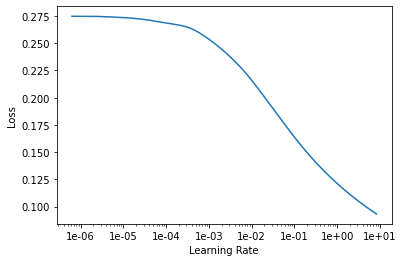

In [21]:
learn.lr_find()
learn.recorder.plot(skip_end = 0)

Training...

In [22]:
learn.fit_one_cycle(7, 5e-2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.011189,0.007965,0.089153,00:23
1,0.001876,0.001656,0.040576,00:24
2,0.001239,0.000901,0.029927,00:23
3,0.000824,0.000768,0.027631,00:23
4,0.000687,0.000642,0.025232,00:23
5,0.000585,0.000576,0.023928,00:23
6,0.000498,0.000554,0.023447,00:23


#Ensembling the 5 models

In [0]:
i = 1

# Run this cell for each model

Saving the submission file to a CSV

In [24]:
# Look at the sample submission file
ss = pd.read_csv('ss.csv')
preds, y = learn.get_preds(DatasetType.Test)
ss['Prediction'] = preds[:,0]

# Save ready for submission:
name = 'submissions/ensamble_'+ str(i) +'.csv'
ss.to_csv(name, index=False)
i += 1

FileNotFoundError: ignored

#Ensamble all the model's predictions for the final submission


In [0]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import gmean

sub_path = Path('submissions/')
csv_files = list(sub_path.glob('*.csv'))
csv_files = sorted(csv_files)
dfs = []
for c in csv_files:
    dfs.append(pd.read_csv(c))

arrs = [np.array(p['Prediction']) for p in dfs]
new_preds = sum(arrs)/len(arrs)
new_df = dfs[0].copy()
new_df['Prediction'] = new_preds

new_df.to_csv('final_sub.csv', index=False)